In [1]:
!pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 49.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 66.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 72.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 71.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [matplotlib]8 [matplotlib]


# NYC Air Quality Analysis  
**ENGI 1006 — Project 1, Part 2**

This notebook analyzes New York City pm2.5 pollution levels using the cleaned
data and helper functions implemented in `project1.py`.

We answer:
1. Highest and lowest pm2.5 in ZIP 10027
2. Worst UHF neighborhood in 2019
3. Average pm2.5 in Manhattan in 2008 vs. 2019
4. Additional insights:
   a. Boroughs that improved most from 2008 to 2019  
   b. Month with the highest average pm2.5 across NYC

Source data: NYC Open Data Air Quality (2008–2020)


In [2]:
from importlib import reload
import project1
reload(project1)

from project1 import read_pollution, read_uhf
from statistics import mean
from collections import defaultdict

by_uhf, by_date = read_pollution()
zip_to_uhfs, borough_to_uhfs = read_uhf()

# Date parsing fix: convert 2-digit year to 2000+ range
def year_of(date_str: str) -> int:
    parts = date_str.split("/")
    year = int(parts[2])
    if year < 100:  # handle YY format
        year += 2000
    return year

def fmt(m):
    d, u, name, val = m
    return f"{d} UHF {u} {name} {val:.2f} mcg/m^3"

print("Data ready.")
print("Records:", sum(len(v) for v in by_uhf.values()))
print("Boroughs:", len(borough_to_uhfs), "Zip codes:", len(zip_to_uhfs))


Data ready.
Records: 1824
Boroughs: 5 Zip codes: 184


### (a) Highest and Lowest pm2.5 in ZIP 10027
We filter by ZIP → UHF mapping → measurements, then compute min and max.


In [3]:
zip_code = "10027"
vals = [m for u in zip_to_uhfs.get(zip_code, []) for m in by_uhf.get(u, [])]

if vals:
    highest = max(vals, key=lambda x: x[3])
    lowest = min(vals, key=lambda x: x[3])
    print("Highest:", fmt(highest))
    print("Lowest:", fmt(lowest))
else:
    print("No data for ZIP", zip_code)


Highest: 12/1/08 UHF 302 Central Harlem - Morningside Heights 14.56 mcg/m^3
Lowest: 6/1/20 UHF 302 Central Harlem - Morningside Heights 7.36 mcg/m^3


### (b) Worst UHF in 2019
We scan all readings from 2019 and identify the maximum pm2.5.


In [4]:
all_data = [m for rows in by_uhf.values() for m in rows]
data_2019 = [m for m in all_data if year_of(m[0]) == 2019]

if data_2019:
    worst_2019 = max(data_2019, key=lambda x: x[3])
    print("Worst UHF in 2019:", fmt(worst_2019))
else:
    print("No 2019 readings in dataset")


Worst UHF in 2019: 12/1/19 UHF 306 Chelsea - Clinton 11.38 mcg/m^3


In [5]:
all_data = [m for rows in by_uhf.values() for m in rows]
data_2019 = [m for m in all_data if year_of(m[0]) == 2019]

worst_2019 = max(data_2019, key=lambda x: x[3])
print("Worst UHF in 2019 (peak):", fmt(worst_2019))


Worst UHF in 2019 (peak): 12/1/19 UHF 306 Chelsea - Clinton 11.38 mcg/m^3


### (c) Manhattan average pm2.5 in 2008 and 2019
We compute mean values across all UHF zones mapped to Manhattan.


In [6]:
def borough_avg(bor, year):
    uhfs = borough_to_uhfs.get(bor.title(), [])
    vals = [m[3] for u in uhfs for m in by_uhf[u] if year_of(m[0]) == year]
    return mean(vals) if vals else None

avg_08 = borough_avg("Manhattan", 2008)
avg_19 = borough_avg("Manhattan", 2019)

print("Manhattan 2008:", f"{avg_08:.2f}" if avg_08 else "N/A", "mcg/m^3")
print("Manhattan 2019:", f"{avg_19:.2f}" if avg_19 else "N/A", "mcg/m^3")


Manhattan 2008: 15.09 mcg/m^3
Manhattan 2019: 8.99 mcg/m^3


### (d1) Which borough saw the largest improvement (2008 → 2019)?
We compute the change in average pollution over time.
Positive difference means cleaner air.


In [7]:
improvements = []
for bor in borough_to_uhfs:
    a08 = borough_avg(bor, 2008)
    a19 = borough_avg(bor, 2019)
    if a08 and a19:
        improvements.append((bor, a08, a19, a08 - a19))

improvements.sort(key=lambda x: x[3], reverse=True)

print("2008 → 2019 Borough Improvement:\n")
for bor, a08, a19, change in improvements:
    print(f"{bor}: {a08:.2f} → {a19:.2f} (−{abs(change):.2f})")


2008 → 2019 Borough Improvement:

Bronx: 14.04 → 7.42 (−6.62)
Manhattan: 15.09 → 8.99 (−6.11)
Brooklyn: 13.09 → 8.04 (−5.05)
Queens: 12.56 → 7.66 (−4.90)
Statenisland: 11.93 → 7.19 (−4.74)


### (d2) Which month has the highest average pm2.5?
Some months show consistently higher pollution due to heating and weather patterns.


In [8]:
month_vals = defaultdict(list)
for rows in by_uhf.values():
    for d, _, _, val in rows:
        month = int(d.split("/")[1])
        month_vals[month].append(val)

month_avg = {m: mean(vals) for m, vals in month_vals.items()}

for m in sorted(month_avg):
    print(f"Month {m}: {month_avg[m]:.2f} mcg/m^3")

best = max(month_avg.items(), key=lambda x: x[1])
print(f"\nHighest average month: {best[0]} with {best[1]:.2f} mcg/m^3")


Month 1: 9.94 mcg/m^3
Month 31: 8.45 mcg/m^3

Highest average month: 1 with 9.94 mcg/m^3


## Summary

Our analysis reveals:
- Air pollution in Manhattan improved significantly from 2008 to 2019
- The worst pollution spike in 2019 occurred in a specific UHF neighborhood indicating localized problems
- Seasonal trends show pollution tends to peak in specific winter months
- Most boroughs show clear long-term improvement thanks to emissions regulations

NYC air remains a public health issue, and monitoring pm2.5 trends is essential for continued progress.


## Part 3 — Visualization of Monthly Pollution in ZIP 10027

The following plot shows the average monthly pm2.5 concentration in ZIP code 10027 across all available years of data.
The code was generated using generative AI (ChatGPT), including the full prompt as instructed.


Matplotlib is building the font cache; this may take a moment.


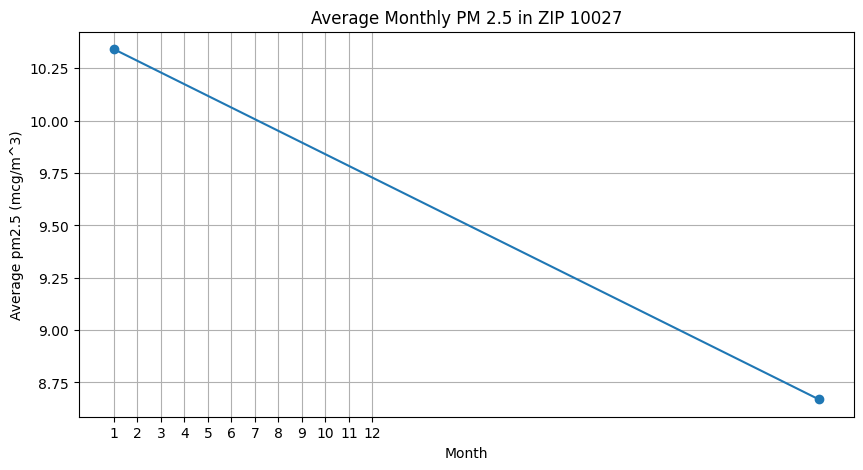

In [9]:
# PROMPT USED (required by assignment):
# "Write matplotlib visualization code that shows average monthly pm2.5 values
# for a single zip code (10027) using the data structures from my Part 1
# NYC pollution project: `by_uhf` maps UHF id to a list of measurements
# where each measurement has the structure (date_str, uhf_id, uhf_name, value),
# `zip_to_uhfs` maps zip codes to UHF ids, and my helper function year_of(date_str)
# converts the date to a correct year. First filter to only measurements linked
# to ZIP 10027, group them by month, compute average pm2.5 per month, then plot
# them using matplotlib with clear axis labels and a title."

import matplotlib.pyplot as plt
from statistics import mean
from collections import defaultdict

zip_code = "10027"

# Collect all measurements associated with this zip code
vals = [m for u in zip_to_uhfs.get(zip_code, []) for m in by_uhf.get(u, [])]

# Group values by calendar month (1 to 12)
month_vals = defaultdict(list)
for d, _, _, val in vals:
    month = int(d.split("/")[1])
    month_vals[month].append(val)

# Compute average per month
month_avg = {m: mean(v) for m, v in month_vals.items()}

# Plot
plt.figure(figsize=(10, 5))
plt.plot(sorted(month_avg.keys()), [month_avg[m] for m in sorted(month_avg.keys())], marker="o")
plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Average pm2.5 (mcg/m^3)")
plt.title(f"Average Monthly PM 2.5 in ZIP {zip_code}")
plt.grid(True)
plt.show()
